In [58]:
import torch
from basicsr.models import create_model
from basicsr.utils import img2tensor as _img2tensor, tensor2img, imwrite
from basicsr.utils.options import parse
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

BATCH_SIZE = 32

In [68]:
def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

def img2tensor(img, bgr2rgb=False, float32=True):
    img = img.astype(np.float32) / 255.
    return _img2tensor(img, bgr2rgb=bgr2rgb, float32=float32)

def display(img1, img2):
  fig = plt.figure(figsize=(25, 10))
  ax1 = fig.add_subplot(1, 2, 1)
  plt.title('Input image', fontsize=16)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, 2, 2)
  plt.title('NAFNet output', fontsize=16)
  ax2.axis('off')
  ax1.imshow(img1)
  ax2.imshow(img2)

def process_images(model, images_tensor):
  model.feed_data(data={'lq': images_tensor})
  model.test()
  visuals = model.get_current_visuals()
  out_imgs = []
  for out_tensor in visuals['result']:
      out_img = tensor2img(out_tensor)
      final_img = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
      out_imgs.append(final_img)
  return out_imgs



## Create Model

In [56]:
opt_path = './options/test/REDS/NAFNet-width64.yml'
opt = parse(opt_path, is_train=False)
opt['dist'] = False
NAFNet = create_model(opt)
model = NAFNet

2024-05-08 18:20:37,118 INFO: Loading NAFNetLocal model from C:/Users/BEN/Desktop/ImageDeBlur/NAFNet/experiments/pretrained_models/NAFNet-REDS-width64.pth.


 load net keys <built-in method keys of dict object at 0x000002833652D548>


2024-05-08 18:20:37,495 INFO: Model [ImageRestorationModel] is created.


# Inference and Show results

In [59]:
input_path = './input/00000000.png'
output_path = './output/00000000.png'

img_input = imread(input_path)
img_inp = img2tensor(img_input)

In [60]:
# inp2 = torch.tensor([inp,inp])
inp = torch.unsqueeze(img_inp, 0)
inp2 = torch.cat([inp, inp], 0)

In [62]:
imgs = process_images(NAFNet, inp2)

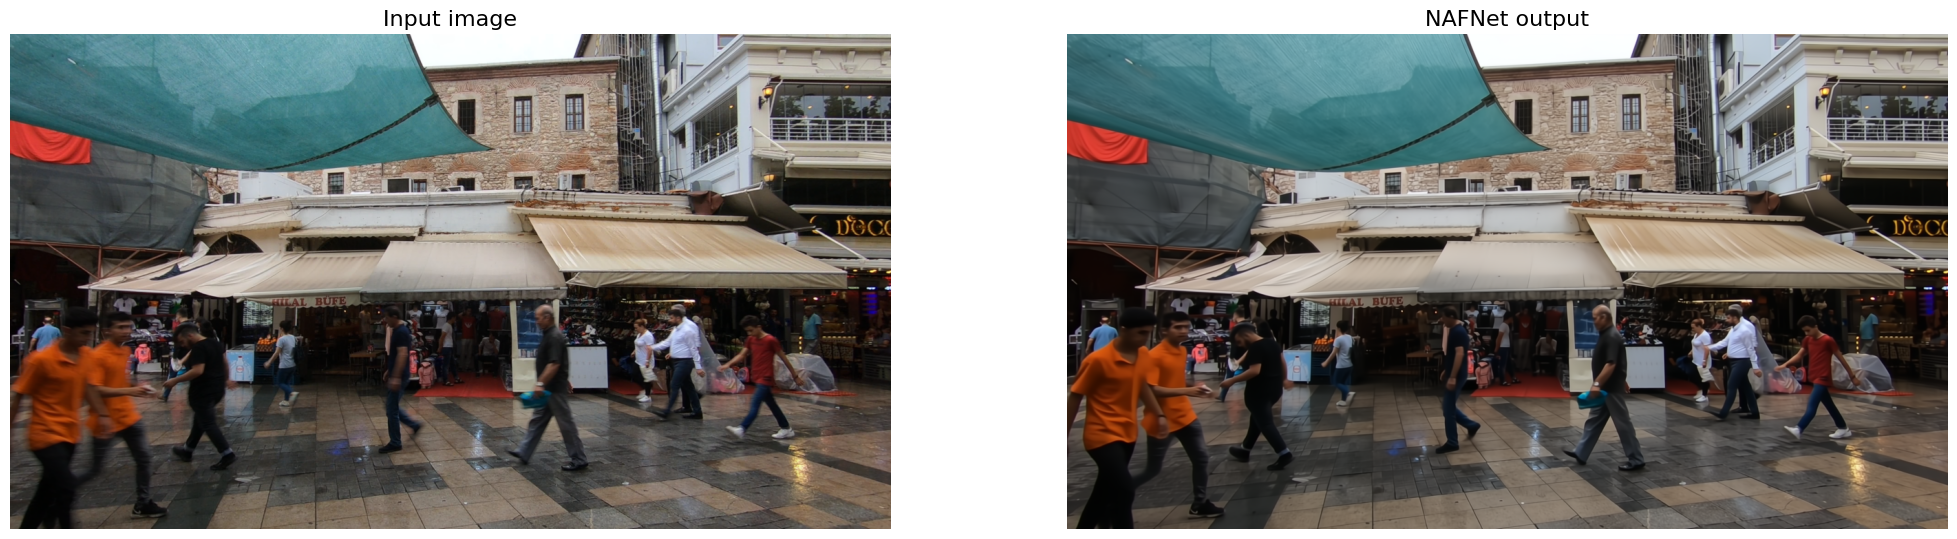

In [63]:
display(img_input, imgs[1])

In [69]:
def process_video(model, video_path, output_folder):
    # Create a VideoCapture object
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Adjust codec based on your needs

    # Prepare output video path
    base_filename = os.path.basename(video_path)
    output_filename = os.path.splitext(base_filename)[0] + "_deblured.mp4"
    output_path = os.path.join(output_folder, output_filename)
    
    # Create a VideoWriter object
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    batch_frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frame to tensor and normalize
        frame_tensor = img2tensor(frame)
        batch_frames.append(frame_tensor)

        # If batch size is reached, process the batch
        if len(batch_frames) == BATCH_SIZE:
            batch_tensor = torch.cat(batch_frames, dim=0)  # Concatenate along the batch dimension
            processed_images = process_images(model, batch_tensor)
            for img in processed_images:
                out.write(img)
            batch_frames = []  # Reset for next batch

    # Process any remaining frames in the last batch
    if batch_frames:
        batch_tensor = torch.cat(batch_frames, dim=0)
        processed_images = process_images(model, batch_tensor)
        for img in processed_images:
            out.write(img)

    # Release everything when job is finished
    cap.release()
    out.release()

In [71]:
model, video_path, output_folder = NAFNet, './input/test.mp4', './output'

In [87]:
cap = cv2.VideoCapture(video_path)
# if not cap.isOpened():
#     print("Error: Could not open video.")
#     return

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Adjust codec based on your needs
# Prepare output video path
base_filename = os.path.basename(video_path)
output_filename = os.path.splitext(base_filename)[0] + "_deblured.mp4"
output_path = os.path.join(output_folder, output_filename)

# Create a VideoWriter object
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

batch_frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to tensor and normalize
    frame_tensor = torch.unsqueeze(img2tensor(frame), 0)
    batch_frames.append(frame_tensor)

    # If batch size is reached, process the batch
    if len(batch_frames) == BATCH_SIZE:
        batch_tensor = torch.cat(batch_frames, dim=0)  # Concatenate along the batch dimension
        print(batch_tensor.size())
        processed_images = process_images(model, batch_tensor)
        for img in processed_images:
            out.write(img)
        batch_frames = []  # Reset for next batch

# Process any remaining frames in the last batch
if batch_frames:
    batch_tensor = torch.cat(batch_frames, dim=0)
    
    processed_images = process_images(model, batch_tensor)
    for img in processed_images:
        out.write(img)

# Release everything when job is finished
cap.release()
out.release()

torch.Size([6, 3, 720, 1280])
